A simple linear network to predict different fashion items (shirts, shoes, etc.)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms, utils, datasets

In [3]:
#Very simple linear sequential network with only a few layers.
class LinearNetwork(nn.Module):
    def __init__(self, dataset):
        super(LinearNetwork, self).__init__()
        x, y = dataset[0] 
        c, h, w = x.size()
        out = y.size(0)
        
        self.net = nn.Sequential(nn.Linear(c * h * w, 1000),nn.Sigmoid(),nn.Linear(1000,2000),nn.Sigmoid(),nn.Linear(2000,out))
        
    def forward(self, x):
        n, c, h, w = x.size()
        flattened = x.view(n, c* h * w)
        return self.net(flattened)

#A class for getting all of the data
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self,root, train=True):
        self.data = datasets.FashionMNIST(root, train=train, transform=transforms.ToTensor(), download = True)
        self.e = torch.eye(10)
    
    def __getitem__(self, i):
        x, y = self.data[i]
        return x, self.e[y].float()
    
    def __len__(self):
        return 5 #len(self.data)

#Get the data
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

#Initialize the model, loss function and optimizer
model = LinearNetwork(train_dataset)
model = model.cuda()
objective = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

#Get a dataloader to make batches of data
train_loader = DataLoader(train_dataset, batch_size=5, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=5, pin_memory=True)

#Create lists for storing information
losses = []
val_losses = []
loop = tqdm(total=len(train_loader)*1000, position=0)

#Do 1000 epochs and keep track of the information
for epoch in range(1000):
    
    #Load the data
    for x, y_truth in train_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True) 
        
        #Get the predicted value and actual value
        optimizer.zero_grad()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        
        #Append the loss and update the update bar
        losses.append(loss)
        loop.set_description('loss:{:.4f}'.format(loss.item()))
        loop.update(1)
        
        #Update the model
        loss.backward()
        optimizer.step()
    
    #A validation loop 
    for x, y_truth in val_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        
        #Check the loss on our validation loop
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        
        val_losses.append(loss)

loop.close()

Processing...
Done!


loss:0.0560: 100%|██████████| 1000/1000 [00:04<00:00, 203.14it/s]


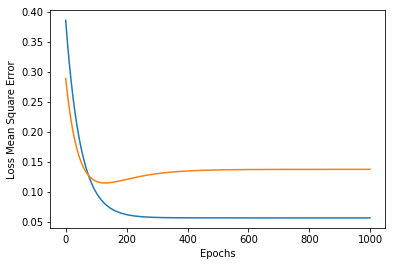

In [4]:
#Plot the losses that we observed
plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss Mean Square Error")
plt.show()